In [7]:
%matplotlib notebook

#functions
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import SimpleITK as sitk
import read as rd
import funkcije as fun
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, mannwhitneyu

import sys
import math

sys.path.append('/opt/medana')
from common.filters import OrientImage
from registration.filters import NiftyregLinear
from registration.filters import NiftyregBSpline
from registration.filters import NiftyregResample
from collections import Counter
from random import seed; from random import shuffle

print('importing done')

importing done


## All MR images and results are on the next link:
https://drive.google.com/drive/folders/1g2mEC_Y6dAHasvZI3toIV5QH6VHKwC4V?usp=sharing

In [8]:
def get_slice(image):
    arr = sitk.GetArrayFromImage(image)
    return arr[:, :, arr.shape[-1]//2]

def get_slice_array(image):
    arr = image
    return arr[:, :, arr.shape[-1]//2]

In [9]:
def elastix_affine(fix_img, mov_img, param, output_dir):
    !/opt/elastix/bin/elastix -f $fix_img -m $mov_img -p $param -out $output_dir

def elastix_bspline(fix_img, mov_img, param, output_dir, trans_param):
    !/opt/elastix/bin/elastix -f $fix_img -m $mov_img -p $param -out $output_dir -t0 $trans_param

def transform(output_dir, transform_parameter, in_put):
    !/opt/elastix/bin/transformix -out $output_dir -tp $transform_parameter -in $in_put

## Read atlas, control an parkinsons images

In [10]:
print('reading brain n1')
brain_t1 = rd.read_brain_atlas_t1()
print('reading brain n1 done\n')

print('reading hipokampus subfields')
hipokampus_subfields = rd.read_hippocampus_subfields()
print('reading hipokampus subfields done')

reading brain n1
reading brain n1 done

reading hipokampus subfields
reading hipokampus subfields done


## Read brain control and parkinsons

In [11]:
print('reading read brain control')
brain_control = rd.read_brain_control()
print('reading read brain control\n')

print('reading read brain parkinson')
brain_parkins = rd.read_brain_parkinson()
print('reading read brain parkinson\n')

reading read brain control
reading read brain control

reading read brain parkinson
reading read brain parkinson



## Change orienatation in all images 

In [12]:
def changeOrientation():
    for  i in range(len(brain_control_read)):
        brain_control_read[i].SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
        sitk.WriteImage(brain_control_read[i], 'Slike_mri/Neurocon/kontrolne_osebe/nii/orientImage/sub-control0320'+str(14+i)+'_T1wOrient.nii.gz')

    for  i in range(len(brain_parkinson_read)):
        brain_parkinson_read[i].SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
        sitk.WriteImage(brain_parkinson_read[i], 'Slike_mri/Neurocon2/osebe_z_parkinsonovo/nii/orientImage/sub-patient0320'+str(30+i)+'_T1wOrient.nii.gz')


## ---------------------------------------------------------------------------------------------------------------------------------

## Affine - Bspline transformation Control MRI

In [13]:
def affineBsplineControl():
    bran_atlas = 'Slike_mri/Cobralab/Brains_t1/nii/'
    hip_sub = 'Slike_mri/Cobralab/Atlases-master/hippocampus-subfields/labels/nii/'
    param_affine = 'parameters/Par0000affine_new.txt'
    param_bspline = 'parameters/Par0000bspline.txt'
    control = 'Slike_mri/Neurocon/kontrolne_osebe/nii/orientImage/'
    parkins = 'Slike_mri/Neurocon/osebe_z_parkinsonovo/nii/orientImage/'
    
    for i in range(16):
        out = 'Slike_mri/Neurocon2/kontrolne_osebe/nii/'+str(0+i)+'/'
        for o in range(5):
            if o==0:
                output_dir1 = out+'0'; output_dir2 = out+'1'; output_dir3 = out+'2'; output_dir4 = out+'3'
            if o==1:
                output_dir1 = out+'4'; output_dir2 = out+'5'; output_dir3 = out+'6'; output_dir4 = out+'7'
            if o==2:
                output_dir1 = out+'8'; output_dir2 = out+'9'; output_dir3 = out+'10'; output_dir4 = out+'11'
            if o==3:
                output_dir1 = out+'12'; output_dir2 = out+'13'; output_dir3 = out+'14'; output_dir4 = out+'15'
            if o==4:
                output_dir1 = out+'16'; output_dir2 = out+'17'; output_dir3 = out+'18'; output_dir4 = out+'19'

            transform_parameter1 = output_dir1+'/TransformParameters.0.txt'
            transform_parameter2 = output_dir2+'/TransformParameters.0.txt'

            fix_img = control+'sub-control0320'+str(14+i)+'_T1wOrient.nii.gz';
            mov_img = bran_atlas+'brain'+str(1+o)+'.nii.gz';
            mov_img_sub = hip_sub+'brain'+str(1+o)+'.nii.gz';

            #elastix affice
            elastix_affice(fix_img, mov_img, param_affine, output_dir1)

            #elastix bspline
            elastix_bspline(fix_img, mov_img, param_bspline, output_dir2, transform_parameter1)

            #transform affine
            transform(output_dir1, transform_parameter1, mov_img)

            #transform bspline
            transform(output_dir2, transform_parameter2, mov_img)
            #---------------------------------------------------- sub

            #transform affine mask
            transform(output_dir3, transform_parameter1, mov_img_sub)

            #transform bspline mask
            transform(output_dir4, transform_parameter2, mov_img_sub)

            #------------------------ save file and repeat with new mov_img1 ----------------

            a1 = sitk.ReadImage(output_dir1+'/result.mhd')
            sitk.WriteImage(a1, out+'moving'+str(i)+'_'+str(o)+'.nrrd')

            a2 = sitk.ReadImage(output_dir3+'/result.mhd')
            sitk.WriteImage(a2, out+'moving_sub'+str(i)+'_'+str(o)+'.nrrd')

            mov_img1 = out+'moving'+str(i)+'_'+str(o)+'.nrrd'
            mov_img_sub1 = out+'moving_sub'+str(i)+'_'+str(o)+'.nrrd'
            #---------------------------------------------------------------------------------------------

            #elastix affice
            elastix_affice(fix_img, mov_img1, param_affine, output_dir1)

            #elastix bspline
            elastix_bspline(fix_img, mov_img1, param_bspline, output_dir2, transform_parameter1)

            #transform affine
            transform(output_dir1, transform_parameter1, mov_img1)

            #transform bspline
            transform(output_dir2, transform_parameter2, mov_img1)
            #---------------------------------------------------- sub

            #transform affine mask
            transform(output_dir3, transform_parameter1, mov_img_sub1)

            #transform bspline mask
            transform(output_dir4, transform_parameter2, mov_img_sub1)

## Affine - Bspline transformation Parkinson MRI

In [14]:
def affineBsplineParkinson():
    bran_atlas = 'Slike_mri/Cobralab/Brains_t1/nii/'
    hip_sub = 'Slike_mri/Cobralab/Atlases-master/hippocampus-subfields/labels/nii/'
    param_affine = 'parameters/Par0000affine_new.txt'
    param_bspline = 'parameters/Par0000bspline.txt'
    control = 'Slike_mri/Neurocon/kontrolne_osebe/nii/orientImage/'
    parkins = 'Slike_mri/Neurocon/osebe_z_parkinsonovo/nii/orientImage/'

    for i in range(27):
        out = 'Slike_mri/Neurocon2/osebe_z_parkinsonovo/nii/'+str(0+i)+'/'
        for o in range(5):
            if o==0:
                output_dir1 = out+'0'; output_dir2 = out+'1'; output_dir3 = out+'2'; output_dir4 = out+'3'
            if o==1:
                output_dir1 = out+'4'; output_dir2 = out+'5'; output_dir3 = out+'6'; output_dir4 = out+'7'
            if o==2:
                output_dir1 = out+'8'; output_dir2 = out+'9'; output_dir3 = out+'10'; output_dir4 = out+'11'
            if o==3:
                output_dir1 = out+'12'; output_dir2 = out+'13'; output_dir3 = out+'14'; output_dir4 = out+'15'
            if o==4:
                output_dir1 = out+'16'; output_dir2 = out+'17'; output_dir3 = out+'18'; output_dir4 = out+'19'

            transform_parameter1 = output_dir1+'/TransformParameters.0.txt'
            transform_parameter2 = output_dir2+'/TransformParameters.0.txt'

            fix_img = parkins+'sub-patient0320'+str(30+i)+'_T1wOrient.nii.gz';
            mov_img = bran_atlas+'brain'+str(1+o)+'.nii.gz';
            mov_img_sub = hip_sub+'brain'+str(1+o)+'.nii.gz';

            #elastix affice
            elastix_affice(fix_img, mov_img, param_affine, output_dir1)

            #elastix bspline
            elastix_bspline(fix_img, mov_img, param_bspline, output_dir2, transform_parameter1)

            #transform affine
            transform(output_dir1, transform_parameter1, mov_img)

            #transform bspline
            transform(output_dir2, transform_parameter2, mov_img)
            #---------------------------------------------------- sub

            #transform affine
            transform(output_dir3, transform_parameter1, mov_img_sub)

            #transform bspline
            transform(output_dir4, transform_parameter2, mov_img_sub)

            #------------------------ save file and repeat with new mov_img1 ----------------

            a1 = sitk.ReadImage(output_dir1+'/result.mhd')
            sitk.WriteImage(a1, out+'moving'+str(i)+'_'+str(o)+'.nrrd')

            a2 = sitk.ReadImage(output_dir3+'/result.mhd')
            sitk.WriteImage(a2, out+'moving_sub'+str(i)+'_'+str(o)+'.nrrd')

            mov_img1 = out+'moving'+str(i)+'_'+str(o)+'.nrrd'
            mov_img_sub1 = out+'moving_sub'+str(i)+'_'+str(o)+'.nrrd'
            #---------------------------------------------------------------------------------------------

            #elastix affice
            elastix_affice(fix_img, mov_img1, param_affine, output_dir1)

            #elastix bspline
            elastix_bspline(fix_img, mov_img1, param_bspline, output_dir2, transform_parameter1)

            #transform affine
            transform(output_dir1, transform_parameter1, mov_img1)

            #transform bspline
            transform(output_dir2, transform_parameter2, mov_img1)
            #---------------------------------------------------- sub

            #transform affine mask
            transform(output_dir3, transform_parameter1, mov_img_sub1)

            #transform bspline mask
            transform(output_dir4, transform_parameter2, mov_img_sub1)

## ---------------------------------------------------------------------------------------------------------------------------------

## Read and show all control images first affine

In [156]:
imgControlFirstAffine = []
for i in range (16):
    xx = []
    for o in range(5):
        xx.append((sitk.ReadImage('Slike_mri/Neurocon2/kontrolne_osebe/nii/'+str(0+i)+'/'+'moving'+str(i)+'_'+str(o)+'.nrrd')))
    imgControlFirstAffine.append(xx)
print('readding brain done')

readding brain done


<IPython.core.display.Javascript object>


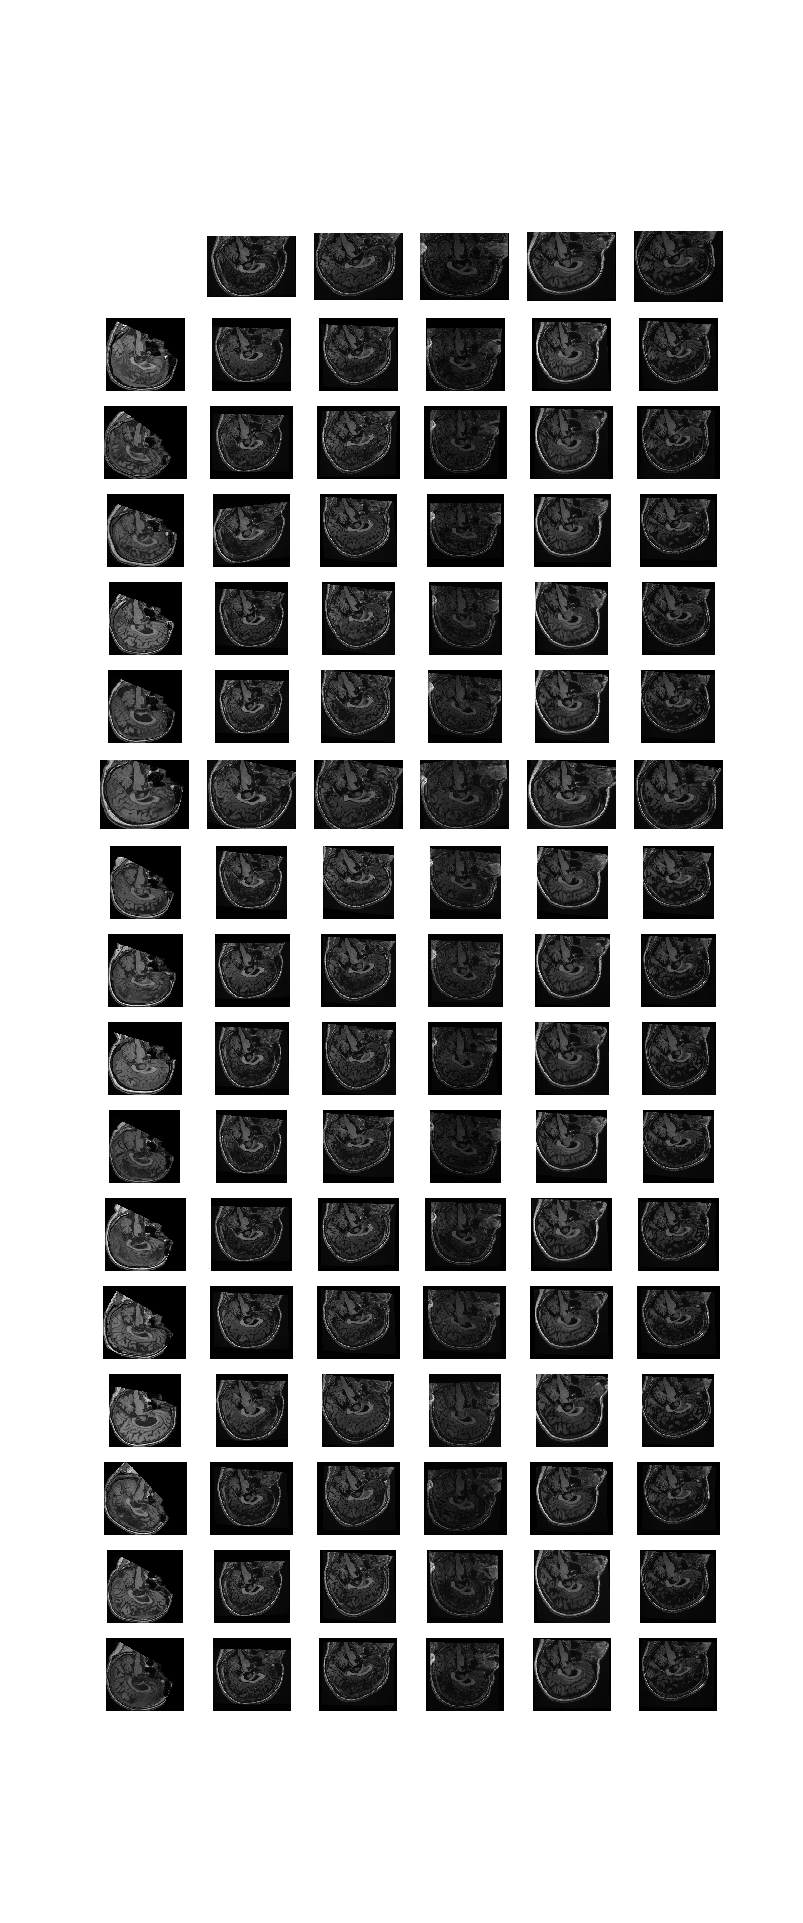

In [157]:
brain_control_switch = brain_control[1:] + [brain_control[0]]
plt.figure()
num_show = 1
for i in range(len(imgControlFirstAffine)+1):
    for o in range(len(imgControlFirstAffine[i-1])+1):
        if i == 0:
            if o != 0:
                #print('brain_t1')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(brain_t1[o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                num_show = num_show+1
        else: 
            if o == 0:
                #print('brain_control')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(brain_control_switch[i-2]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                #print('oImgAffineControl')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(imgControlFirstAffine[i-1][o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')

## Read and show all control images second affine

In [15]:
imgControlAffine = []
num = [0,4, 8, 12, 16]
for i in range (16):
    xx = []
    for o in num:
        xx.append((sitk.ReadImage('Slike_mri/Neurocon2/kontrolne_osebe/nii/'+str(i)+'/'+str(o)+'/result.mhd')))
    imgControlAffine.append(xx)
print('readding brain done')

readding brain done


<IPython.core.display.Javascript object>


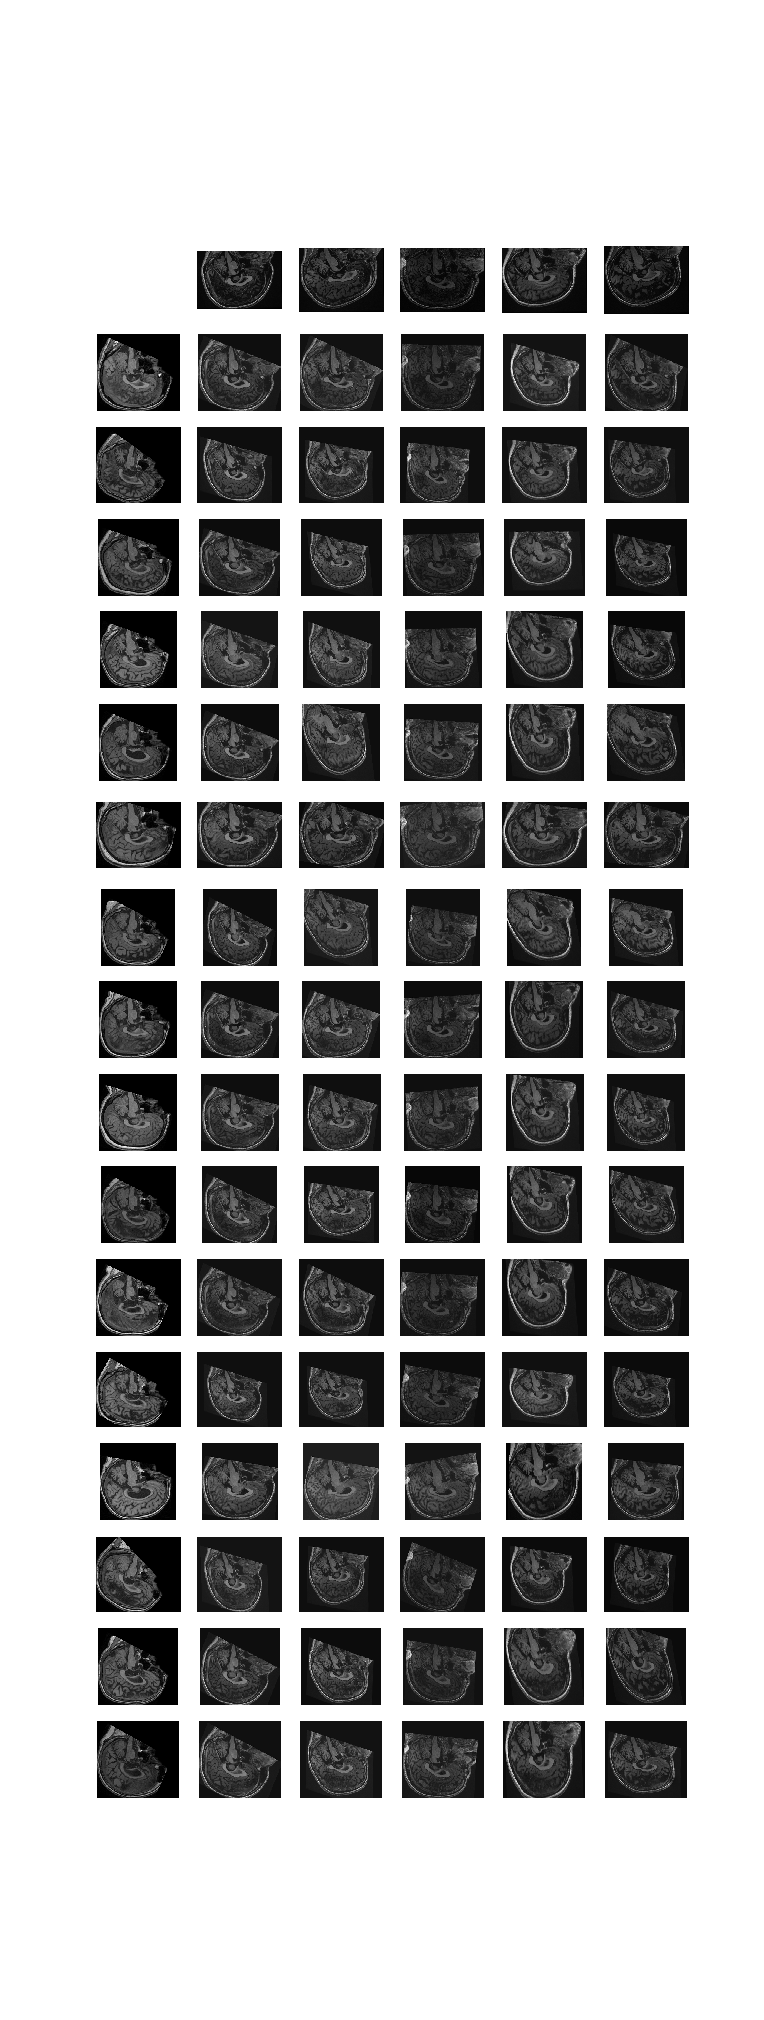

In [151]:
brain_control_switch = brain_control[1:] + [brain_control[0]]
plt.figure()
num_show = 1
for i in range(len(imgControlAffine)+1):
    for o in range(len(imgControlAffine[i-1])+1):
        if i == 0:
            if o != 0:
                #print('brain_t1')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(brain_t1[o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                num_show = num_show+1
        else: 
            if o == 0:
                #print('brain_control')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(brain_control_switch[i-2]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                #print('oImgAffineControl')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(imgControlAffine[i-1][o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')

## Read and show all control images bspline

In [17]:
imgControlBspline = []
num = [1,5,9,13,17]
for i in range (16):
    xx = []
    for o in num:
        xx.append((sitk.ReadImage('Slike_mri/Neurocon2/kontrolne_osebe/nii/'+str(i)+'/'+str(o)+'/result.mhd')))
    imgControlBspline.append(xx)
print('readding brain done')

readding brain done


<IPython.core.display.Javascript object>


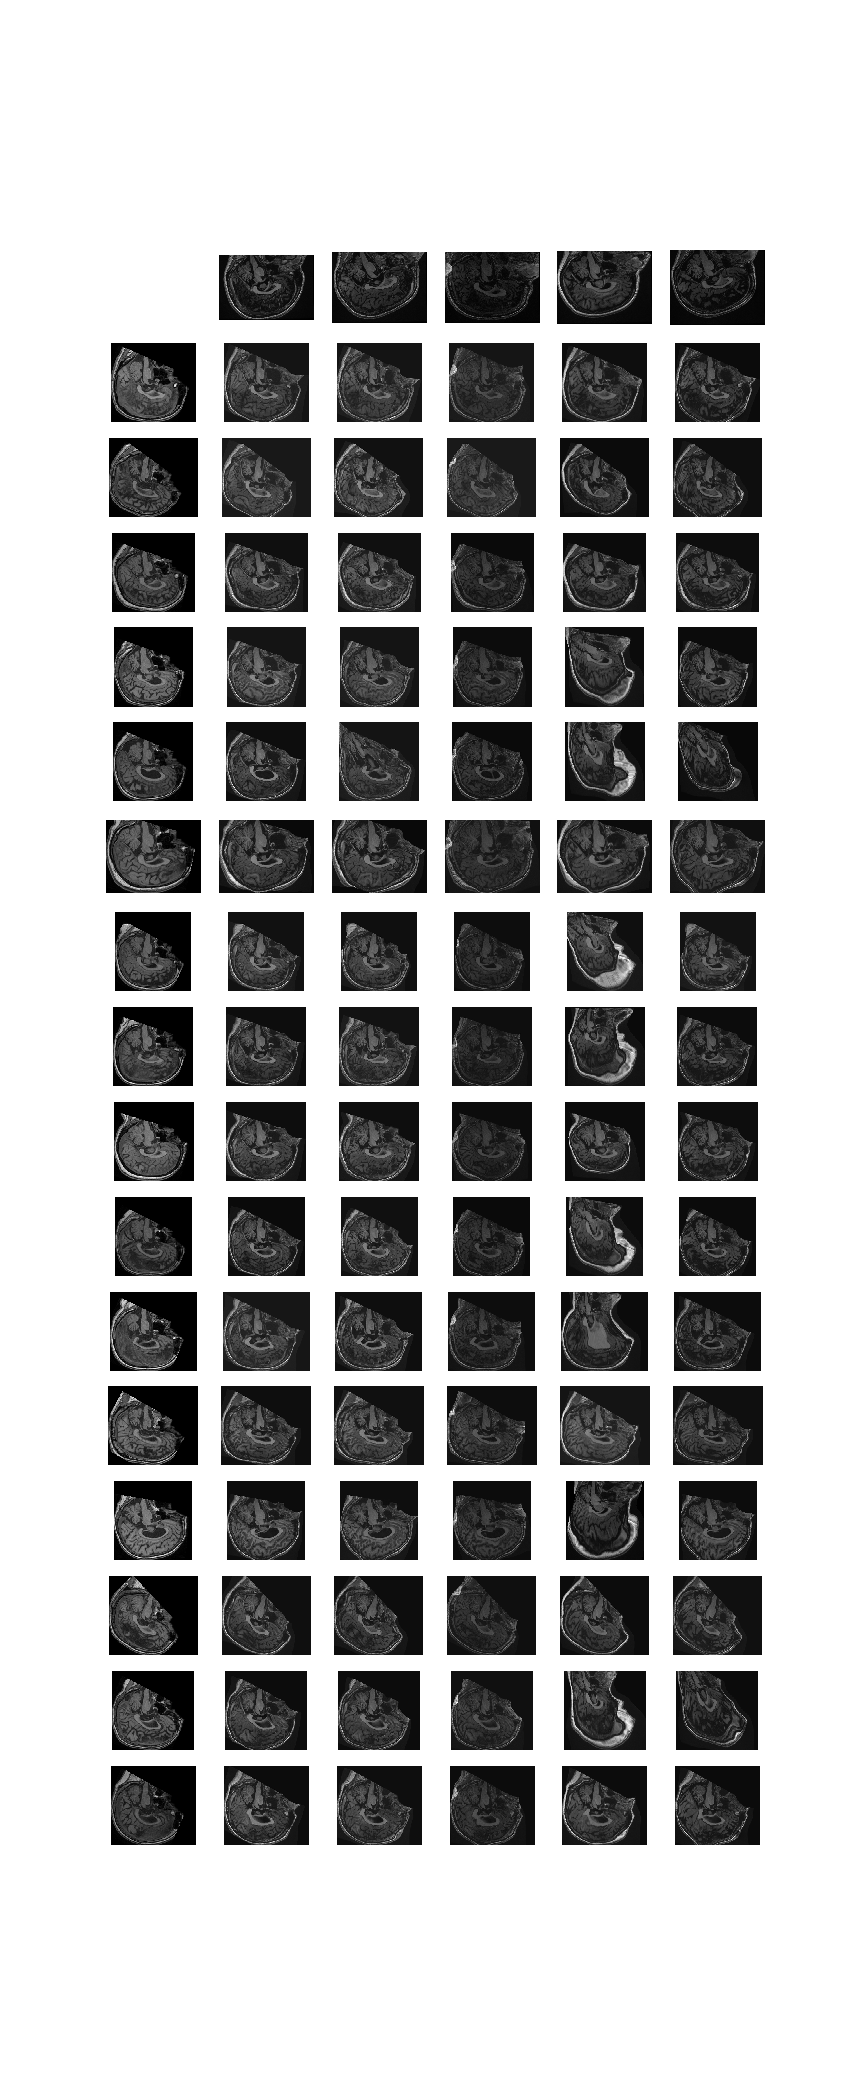

In [152]:
brain_control_switch = brain_control[1:] + [brain_control[0]]
plt.figure()
num_show = 1
for i in range(len(imgControlBspline)+1):
    for o in range(len(imgControlBspline[i-1])+1):
        if i == 0:
            if o != 0:
                #print('brain_t1')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(brain_t1[o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                num_show = num_show+1
        else: 
            if o == 0:
                #print('brain_control')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(brain_control_switch[i-2]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                #print('oImgAffineControl')
                plt.subplot(17,6,num_show); plt.imshow(get_slice(imgControlBspline[i-1][o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')

## Choose best one [MRI 0, MRI 1, MRI 2, MRI 3, MRI 4]

[0, 1, 2, 3, 4]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 4]
[0, 2,]
[0, 1, 2, 3, 4]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2, 3]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2]
[0, 1, 2, 3, 4]


## ---------------------------------------------------------------------------------------------------------------------------------

## Read and show all parkinson Images first affine

In [158]:
imgParkinsonFirstAffine = []
for i in range (27):
    xx = []
    for o in range(5):
        xx.append((sitk.ReadImage('Slike_mri/Neurocon2/osebe_z_parkinsonovo/nii/'+str(0+i)+'/'+'moving'+str(i)+'_'+str(o)+'.nrrd')))
    imgParkinsonFirstAffine.append(xx)
print('readding brain done')

readding brain done


<IPython.core.display.Javascript object>


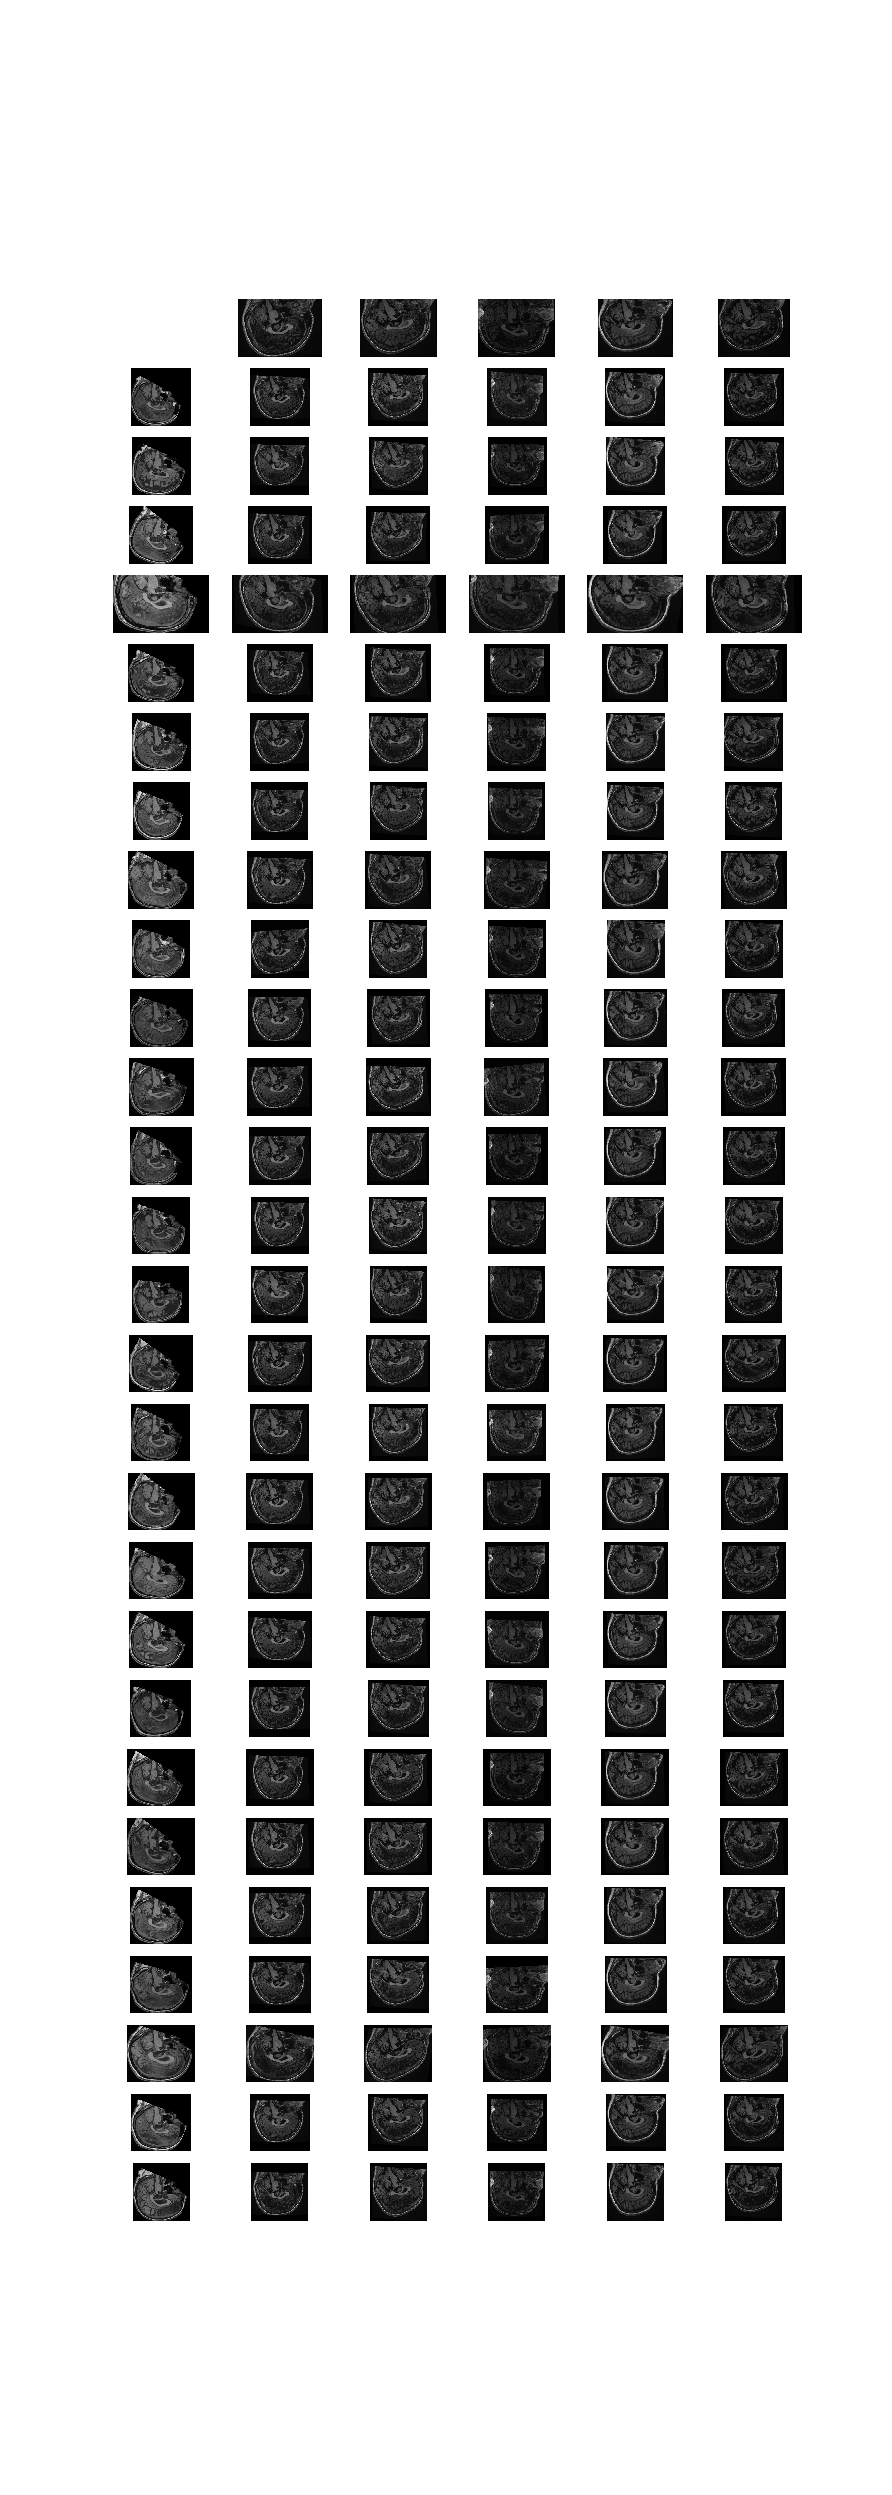

In [162]:
brain_parkins_switch = brain_parkins[1:] + [brain_parkins[0]]
plt.figure()
num_show = 1
for i in range(len(imgParkinsonFirstAffine)+1):
    for o in range(len(imgParkinsonFirstAffine[i-1])+1):
        if i == 0:
            if o != 0:
                #print('brain_t1')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(brain_t1[o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                num_show = num_show+1
        else: 
            if o == 0:
                #print('brain_control')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(brain_parkins_switch[i-2]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                #print('oImgAffineControl')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(imgParkinsonFirstAffine[i-1][o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')

## Read and show all parkinson Images second affine

In [19]:
imgParkinsonAffine = []
num = [0,4,8,12,16]
for i in range(27):
    xx = []
    for o in num:
        xx.append(sitk.ReadImage('Slike_mri/Neurocon2/osebe_z_parkinsonovo/nii/'+str(i)+'/'+str(o)+'/result.mhd'))
    imgParkinsonAffine.append(xx)
print('readding brain done')

readding brain done


<IPython.core.display.Javascript object>


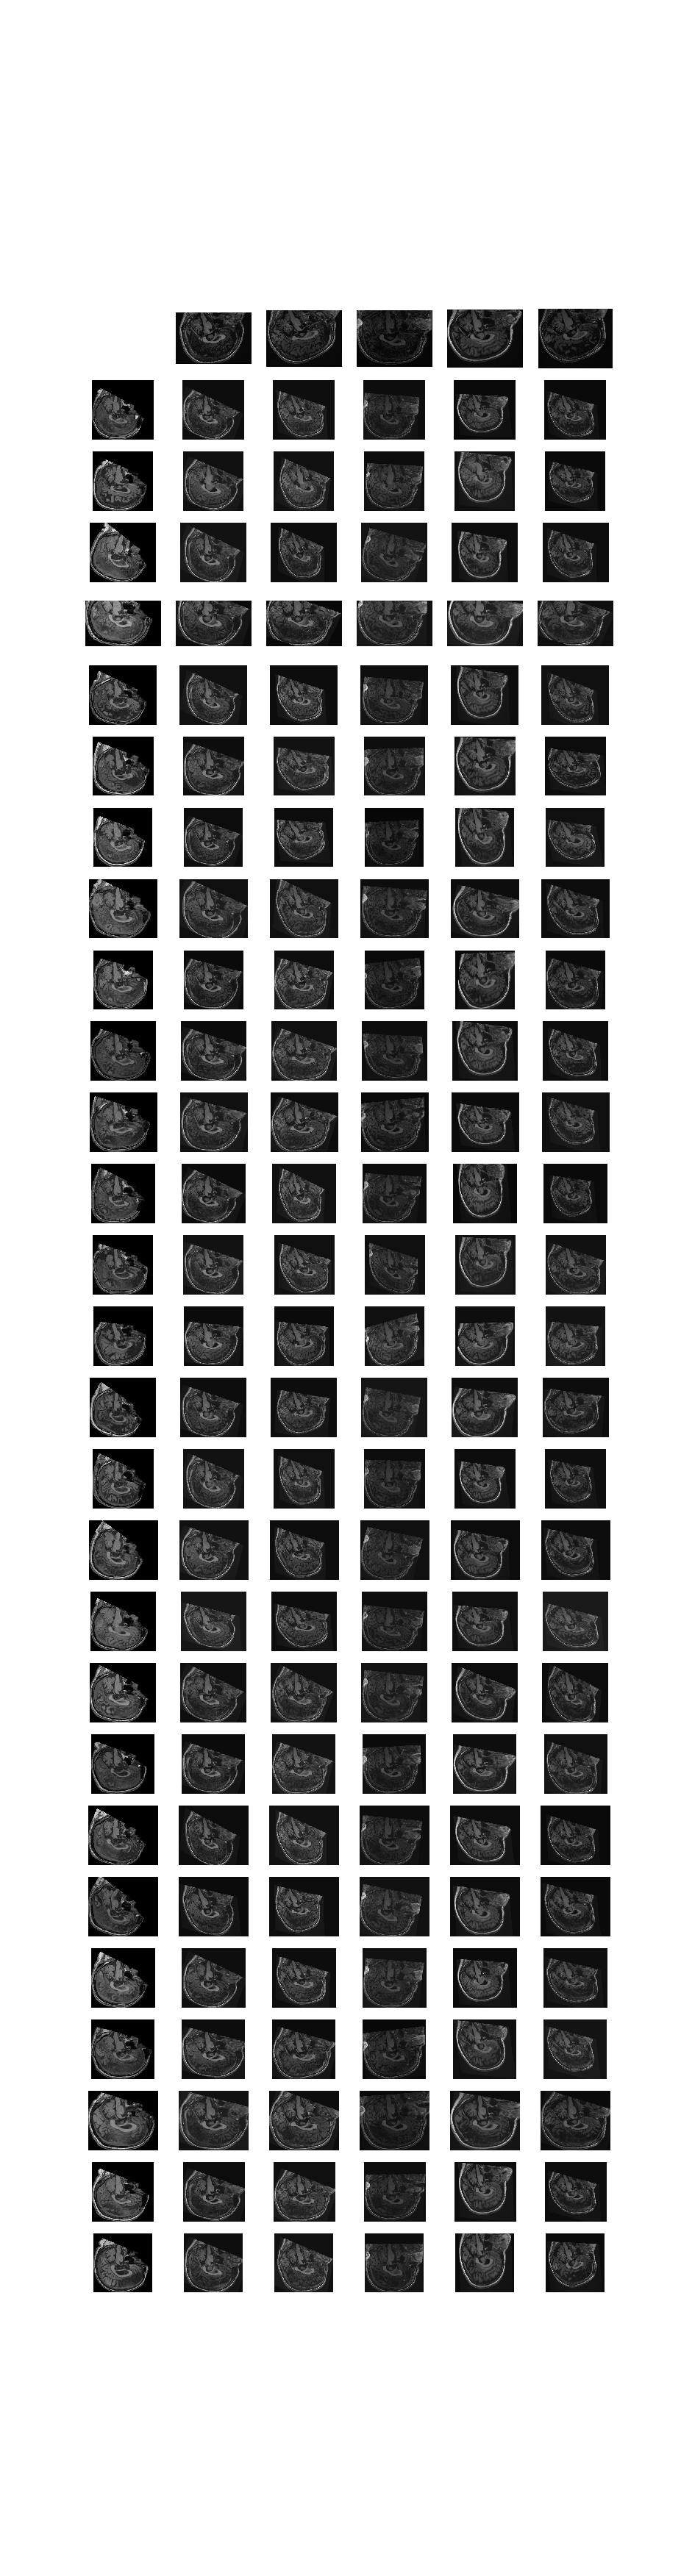

In [153]:
brain_parkins_switch = brain_parkins[1:] + [brain_parkins[0]]
plt.figure()
num_show = 1
for i in range(len(imgParkinsonAffine)+1):
    for o in range(len(imgParkinsonAffine[i-1])+1):
        if i == 0:
            if o != 0:
                #print('brain_t1')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(brain_t1[o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                num_show = num_show+1
        else: 
            if o == 0:
                #print('brain_control')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(brain_parkins_switch[i-2]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                #print('oImgAffineControl')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(imgParkinsonAffine[i-1][o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')

## Read and show all parkinson Images bspline

In [21]:
imgParkinsonBspline = []
#[0,4,8,12,16]
num = [1,5,9,13,17]
for i in range(27):
    xx = []
    for o in num:
        xx.append(sitk.ReadImage('Slike_mri/Neurocon2/osebe_z_parkinsonovo/nii/'+str(i)+'/'+str(o)+'/result.mhd'))
    imgParkinsonBspline.append(xx)
print('readding brain done')

readding brain done


<IPython.core.display.Javascript object>


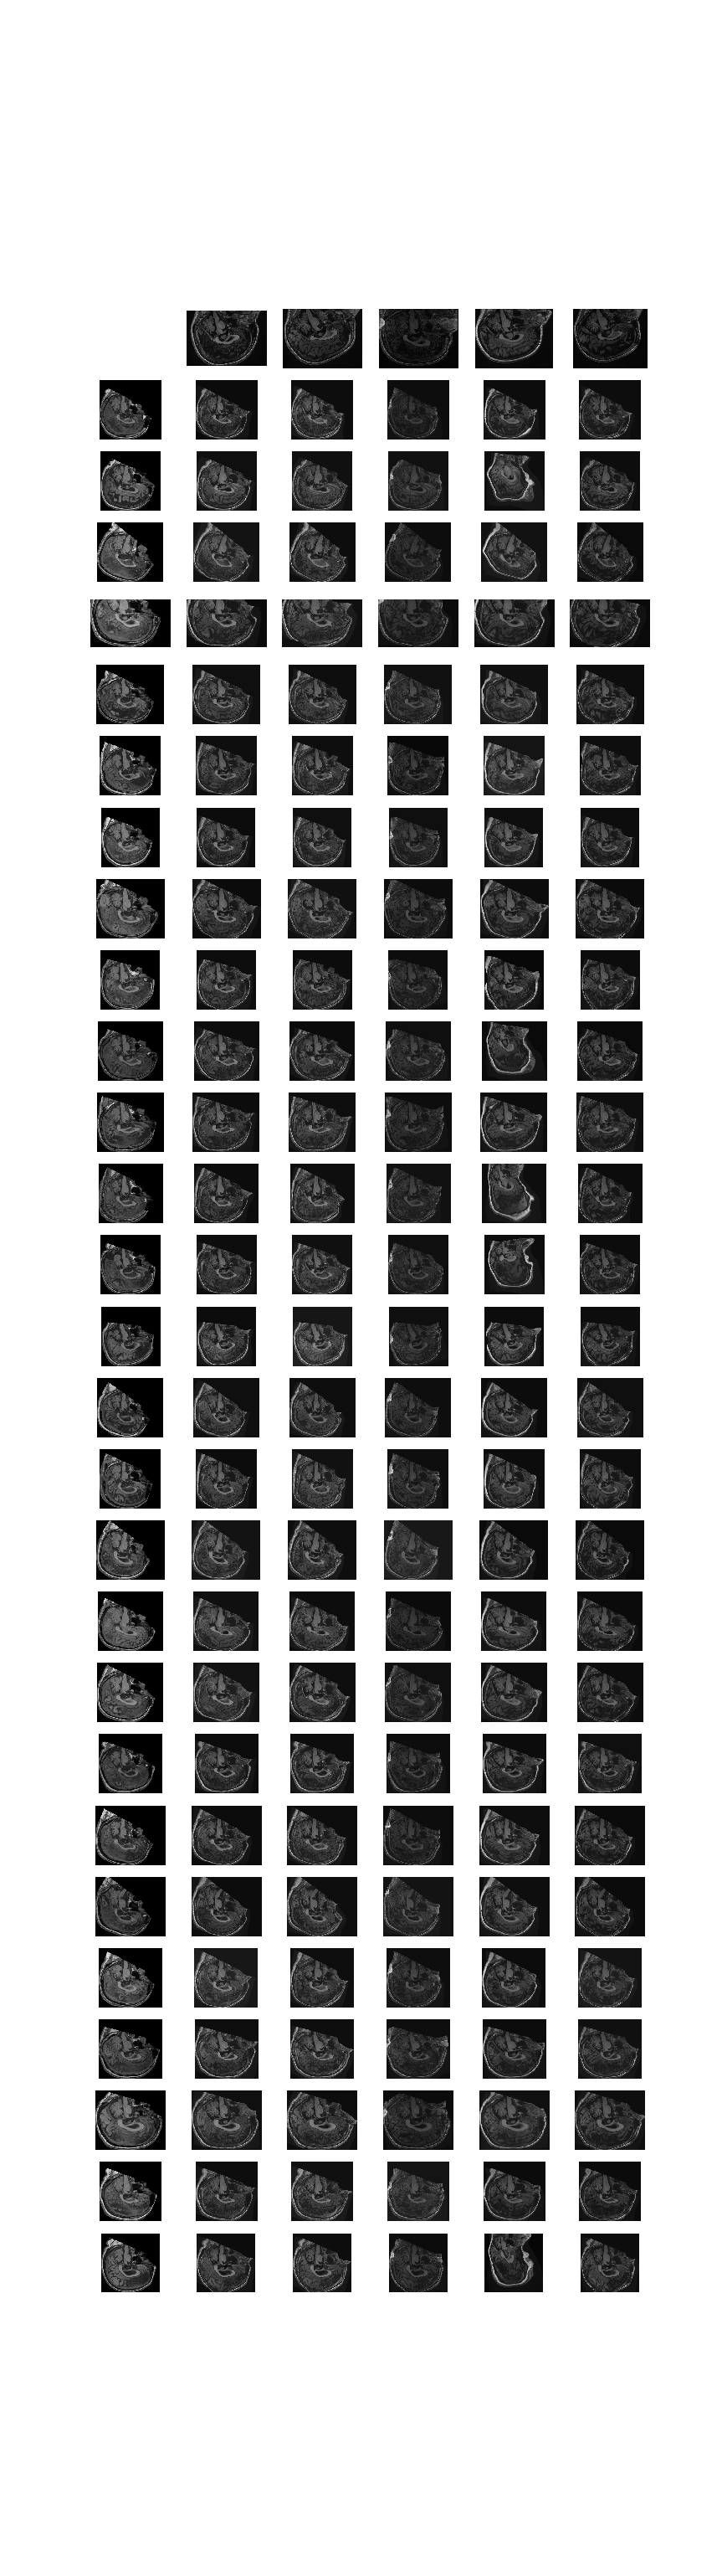

In [163]:
brain_parkins_switch = brain_parkins[1:] + [brain_parkins[0]]
plt.figure()
num_show = 1
for i in range(len(imgParkinsonBspline)+1):
    for o in range(len(imgParkinsonBspline[i-1])+1):
        if i == 0:
            if o != 0:
                #print('brain_t1')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(brain_t1[o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                num_show = num_show+1
        else: 
            if o == 0:
                #print('brain_control')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(brain_parkins_switch[i-2]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')
            else:
                #print('oImgAffineControl')
                plt.subplot(28,6,num_show); plt.imshow(get_slice(imgParkinsonBspline[i-1][o-1]), cmap='gray')
                num_show = num_show+1
                plt.axis('off')

## Choose best one [MRI 0, MRI 1, MRI 2, MRI 3, MRI 4]

[0, 1, 2, 3, 4]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 4]
[0, 1, 2, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
[0, 1, 2, 4]

## ---------------------------------------------------------------------------------------------------------------------------------

## Read control and parkinson mask affine and bsplie

## Mask hippocampus - affine

In [23]:
imgControlAffineMask = []
num = [2,6,10,14,18]
for i in range (16):
    xx = []
    for o in num:
        xx.append((sitk.ReadImage('Slike_mri/Neurocon2/kontrolne_osebe/nii/'+str(i)+'/'+str(o)+'/result.mhd')))
    imgControlAffineMask.append(xx)
print('readding brain done')

readding brain done


## Mask hippocampus bspline

In [24]:
imgControlBsplinemask = []
num = [3,7,11,15,19]
for i in range (16):
    xx = []
    for o in num:
        xx.append((sitk.ReadImage('Slike_mri/Neurocon2/kontrolne_osebe/nii/'+str(i)+'/'+str(o)+'/result.mhd')))
    imgControlBsplinemask.append(xx)
print('readding brain done')

readding brain done


## Save MRI as nrrd file

In [25]:
for i in range(len(imgControlBsplinemask)):
    for o in range (len(imgControlBsplinemask[i])):
        sitk.WriteImage(imgControlBsplinemask[i][o], 'maske/imgControlBsplinemask'+str(i)+str(o)+'.nrrd')

## Choose best one [MRI 0, MRI 1, MRI 2, MRI 3, MRI 4]
[0, 1, 2, 3, 4] [0, 1, 2, 4] [0, 1, 2, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 4] [0, 1, 2, 4] [0, 1, 2, 3, 4] [0, 1, 2, 4] [0, 1, 2, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 3, 4] [0, 1, 2, 4]

In [26]:
imgControlBsplinemask_choosen = []
imgControlBsplinemask_choosen.append([imgControlBsplinemask[0][0], imgControlBsplinemask[0][1], imgControlBsplinemask[0][2], imgControlBsplinemask[0][3], imgControlBsplinemask[0][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[1][0], imgControlBsplinemask[1][1], imgControlBsplinemask[1][2], imgControlBsplinemask[1][3]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[2][0], imgControlBsplinemask[2][1], imgControlBsplinemask[2][2], imgControlBsplinemask[2][3], imgControlBsplinemask[2][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[3][0], imgControlBsplinemask[3][1], imgControlBsplinemask[3][2], imgControlBsplinemask[3][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[4][0], imgControlBsplinemask[4][2]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[5][0], imgControlBsplinemask[5][1], imgControlBsplinemask[5][2], imgControlBsplinemask[5][3], imgControlBsplinemask[5][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[6][0], imgControlBsplinemask[6][1], imgControlBsplinemask[6][2], imgControlBsplinemask[6][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[7][0], imgControlBsplinemask[7][1], imgControlBsplinemask[7][2], imgControlBsplinemask[7][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[8][0], imgControlBsplinemask[8][1], imgControlBsplinemask[8][2], imgControlBsplinemask[8][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[9][0], imgControlBsplinemask[9][1], imgControlBsplinemask[9][2], imgControlBsplinemask[9][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[10][0], imgControlBsplinemask[10][1], imgControlBsplinemask[10][2], imgControlBsplinemask[10][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[11][0], imgControlBsplinemask[11][1], imgControlBsplinemask[11][2], imgControlBsplinemask[11][3]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[12][0], imgControlBsplinemask[12][1], imgControlBsplinemask[12][2], imgControlBsplinemask[12][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[13][0], imgControlBsplinemask[13][1], imgControlBsplinemask[13][2], imgControlBsplinemask[13][4]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[14][0], imgControlBsplinemask[14][1], imgControlBsplinemask[14][2]])
imgControlBsplinemask_choosen.append([imgControlBsplinemask[15][0], imgControlBsplinemask[15][1], imgControlBsplinemask[15][2], imgControlBsplinemask[15][3], imgControlBsplinemask[15][4]])

## Treshold 1.59 based by BrainSeg3D

In [27]:
imgControlBsplinemask_TRESHOLD = []
for i in range(len(imgControlBsplinemask_choosen)):
    img_treshold = []
    for o in range (len(imgControlBsplinemask_choosen[i])):
        img_treshold.append(sitk.BinaryThreshold(imgControlBsplinemask_choosen[i][o],
                                                          lowerThreshold=1.59,
                                                          insideValue=1, outsideValue=0))
    imgControlBsplinemask_TRESHOLD.append(img_treshold)

## Save tresholded MRI

In [122]:
for i in range(len(imgControlBsplinemask_TRESHOLD)):
    for o in range (len(imgControlBsplinemask_TRESHOLD[i])):
        sitk.WriteImage(imgControlBsplinemask_TRESHOLD[i][o], 'maske/tresholdControl/imgControlBsplinemask_treshold'+str(i)+str(o)+'.nrrd')

## Rescale MRI to Uint 16 for LabelVoting()

In [140]:
imgControlBsplinemask_TRESHOLD_UInt16 = []
for i in range(len(imgControlBsplinemask_TRESHOLD)):
    ima_xx = []
    for o in range(len(imgControlBsplinemask_TRESHOLD[i])):
        ima_xx.append(sitk.Cast(sitk.RescaleIntensity(imgControlBsplinemask_TRESHOLD[i][o]), sitk.sitkUInt16))
    imgControlBsplinemask_TRESHOLD_UInt16.append(ima_xx)
    

## LabelVoting()

In [141]:
imgControlBsplinemask_TRESHOLD_UInt16_labelVoting = []
for i in range(len(imgControlBsplinemask_TRESHOLD_UInt16)):
    imgControlBsplinemask_TRESHOLD_UInt16_labelVoting.append(sitk.LabelVoting(imgControlBsplinemask_TRESHOLD_UInt16[i]))

## Save all LabelVoted images

In [144]:
for i in range(len(imgControlBsplinemask_TRESHOLD_UInt16_labelVoting)):
    sitk.WriteImage(imgControlBsplinemask_TRESHOLD_UInt16_labelVoting[i], 'maske/labelVotingControl/imgControlBsplinemask_TRESHOLD_UInt16_labelVoting'+str(i)+'.nrrd')

In [143]:
print('Volumes od control hippocampus:')
for i in range(len(imgControlBsplinemask_TRESHOLD_UInt16_labelVoting)):
    volume_mask = dict(Counter(imgControlBsplinemask_TRESHOLD_UInt16_labelVoting[i]))
    print('volume'+str(i)+': ', volume_mask)

Volumes od control hippocampus:
volume0:  {0: 7701049, 255: 7876}
volume1:  {0: 7630097, 256: 2556, 255: 5647}
volume2:  {0: 7285118, 255: 6937}
volume3:  {0: 6982287, 256: 2952, 255: 6081}
volume4:  {0: 6620198, 256: 5568, 255: 4344}
volume5:  {0: 5322530, 255: 7442}
volume6:  {0: 6501432, 256: 2520, 255: 5208}
volume7:  {0: 7417208, 256: 2720, 255: 6197}
volume8:  {0: 6758159, 256: 2442, 255: 5424}
volume9:  {0: 6730340, 256: 2522, 255: 5078}
volume10:  {0: 7969248, 256: 3459, 255: 6918}
volume11:  {0: 8076272, 256: 2901, 255: 6027}
volume12:  {0: 6624837, 256: 3110, 255: 6058}
volume13:  {0: 8008064, 256: 2424, 255: 5012}
volume14:  {0: 6764632, 255: 8264}
volume15:  {0: 7409802, 255: 8738}


#### Volumes od control hippocampus:
#### volume0:  {0: 7701049, 255: 7876}
#### volume1:  {0: 7630097, 256: 2556, 255: 5647}
#### volume2:  {0: 7285118, 255: 6937}
#### volume3:  {0: 6982287, 256: 2952, 255: 6081}
#### volume4:  {0: 6620198, 256: 5568, 255: 4344}
#### volume5:  {0: 5322530, 255: 7442}
#### volume6:  {0: 6501432, 256: 2520, 255: 5208}
#### volume7:  {0: 7417208, 256: 2720, 255: 6197}
#### volume8:  {0: 6758159, 256: 2442, 255: 5424}
#### volume9:  {0: 6730340, 256: 2522, 255: 5078}
#### volume10:  {0: 7969248, 256: 3459, 255: 6918}
#### volume11:  {0: 8076272, 256: 2901, 255: 6027}
#### volume12:  {0: 6624837, 256: 3110, 255: 6058}
#### volume13:  {0: 8008064, 256: 2424, 255: 5012}
#### volume14:  {0: 6764632, 255: 8264}
#### volume15:  {0: 7409802, 255: 8738}


## Read numbes of voxels in hippocampus in Control brain

In [28]:
volumesControl = [7876, 2556 + 5647, 6937, 2952 + 6081, 5568 + 4344, 7442, 2520 + 5208, 2720 + 6197, 2442 + 5424,
                 2522 + 5078, 3459 + 6918, 2901 + 6027, 3110 + 6058, 2424 + 5012, 8264, 8738]

## Read voxels to mm^2

In [150]:
print(volumesControl); print('')

volumesControlmm = []
for i in range(len(volumesControl)):
    volumesControlmm.append(volumesControl[i]*((brain_control[i].GetSpacing())[0]*
                                                   (brain_control[i].GetSpacing())[1]*
                                                   (brain_control[i].GetSpacing())[2]))

for i in range(len(volumesControlmm)):
    print('Num. of voxels ',i,': ', round(volumesControl[i],2))

[7876, 8203, 6937, 9033, 9912, 7442, 7728, 8917, 7866, 7600, 10377, 8928, 9168, 7436, 8264, 8738]

Num. of voxels  0 :  7876
Num. of voxels  1 :  8203
Num. of voxels  2 :  6937
Num. of voxels  3 :  9033
Num. of voxels  4 :  9912
Num. of voxels  5 :  7442
Num. of voxels  6 :  7728
Num. of voxels  7 :  8917
Num. of voxels  8 :  7866
Num. of voxels  9 :  7600
Num. of voxels  10 :  10377
Num. of voxels  11 :  8928
Num. of voxels  12 :  9168
Num. of voxels  13 :  7436
Num. of voxels  14 :  8264
Num. of voxels  15 :  8738


## Read control and parkinson mask affine and bsplie

## Mask hippocampus - affine

In [42]:
imgParkinsonAffineMask = []
num = [2,6,10,14,18]
for i in range(27):
    xx = []
    for o in num:
        xx.append(sitk.ReadImage('Slike_mri/Neurocon2/osebe_z_parkinsonovo/nii/'+str(i)+'/'+str(o)+'/result.mhd'))
    imgParkinsonAffineMask.append(xx)
print('readding brain done')

readding brain done


## Mask hippocampus bspline

In [43]:
imgParkinsonBsplineMask = []
num = [3,7,11,15,19]
for i in range(27):
    xx = []
    for o in num:
        xx.append(sitk.ReadImage('Slike_mri/Neurocon2/osebe_z_parkinsonovo/nii/'+str(i)+'/'+str(o)+'/result.mhd'))
    imgParkinsonBsplineMask.append(xx)
print('readding brain done')

readding brain done


## Choose only good MRI

In [44]:
## best one
imgParkinsonBsplineMask_choosen = []
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[0][0], imgParkinsonBsplineMask[0][1], imgParkinsonBsplineMask[0][2], imgParkinsonBsplineMask[0][3], imgParkinsonBsplineMask[0][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[1][0], imgParkinsonBsplineMask[1][1], imgParkinsonBsplineMask[1][2], imgParkinsonBsplineMask[1][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[2][0], imgParkinsonBsplineMask[2][1], imgParkinsonBsplineMask[2][2], imgParkinsonBsplineMask[2][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[3][0], imgParkinsonBsplineMask[3][1], imgParkinsonBsplineMask[3][2], imgParkinsonBsplineMask[3][3], imgParkinsonBsplineMask[3][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[4][0], imgParkinsonBsplineMask[4][1], imgParkinsonBsplineMask[4][2], imgParkinsonBsplineMask[4][3], imgParkinsonBsplineMask[4][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[5][0], imgParkinsonBsplineMask[5][1], imgParkinsonBsplineMask[5][2], imgParkinsonBsplineMask[5][3], imgParkinsonBsplineMask[5][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[6][0], imgParkinsonBsplineMask[6][1], imgParkinsonBsplineMask[6][2], imgParkinsonBsplineMask[6][3], imgParkinsonBsplineMask[6][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[7][0], imgParkinsonBsplineMask[7][1], imgParkinsonBsplineMask[7][2], imgParkinsonBsplineMask[7][3], imgParkinsonBsplineMask[7][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[8][0], imgParkinsonBsplineMask[8][1], imgParkinsonBsplineMask[8][2], imgParkinsonBsplineMask[8][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[9][0], imgParkinsonBsplineMask[9][1], imgParkinsonBsplineMask[9][2], imgParkinsonBsplineMask[9][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[10][0], imgParkinsonBsplineMask[10][1], imgParkinsonBsplineMask[10][2], imgParkinsonBsplineMask[10][3], imgParkinsonBsplineMask[10][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[11][0], imgParkinsonBsplineMask[11][1], imgParkinsonBsplineMask[11][2], imgParkinsonBsplineMask[11][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[12][0], imgParkinsonBsplineMask[12][1], imgParkinsonBsplineMask[12][2], imgParkinsonBsplineMask[12][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[13][0], imgParkinsonBsplineMask[13][1], imgParkinsonBsplineMask[13][2], imgParkinsonBsplineMask[13][3], imgParkinsonBsplineMask[13][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[14][0], imgParkinsonBsplineMask[14][1], imgParkinsonBsplineMask[14][2], imgParkinsonBsplineMask[14][3], imgParkinsonBsplineMask[14][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[15][0], imgParkinsonBsplineMask[15][1], imgParkinsonBsplineMask[15][2], imgParkinsonBsplineMask[15][3], imgParkinsonBsplineMask[15][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[16][0], imgParkinsonBsplineMask[16][1], imgParkinsonBsplineMask[16][2], imgParkinsonBsplineMask[16][3], imgParkinsonBsplineMask[16][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[17][0], imgParkinsonBsplineMask[17][1], imgParkinsonBsplineMask[17][2], imgParkinsonBsplineMask[17][3], imgParkinsonBsplineMask[17][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[18][0], imgParkinsonBsplineMask[18][1], imgParkinsonBsplineMask[18][2], imgParkinsonBsplineMask[18][3], imgParkinsonBsplineMask[18][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[19][0], imgParkinsonBsplineMask[19][1], imgParkinsonBsplineMask[19][2], imgParkinsonBsplineMask[19][3], imgParkinsonBsplineMask[19][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[20][0], imgParkinsonBsplineMask[20][1], imgParkinsonBsplineMask[20][2], imgParkinsonBsplineMask[20][3], imgParkinsonBsplineMask[20][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[21][0], imgParkinsonBsplineMask[21][1], imgParkinsonBsplineMask[21][2], imgParkinsonBsplineMask[21][3], imgParkinsonBsplineMask[21][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[22][0], imgParkinsonBsplineMask[22][1], imgParkinsonBsplineMask[22][2], imgParkinsonBsplineMask[22][3], imgParkinsonBsplineMask[22][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[23][0], imgParkinsonBsplineMask[23][1], imgParkinsonBsplineMask[23][2], imgParkinsonBsplineMask[23][3], imgParkinsonBsplineMask[23][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[24][0], imgParkinsonBsplineMask[24][1], imgParkinsonBsplineMask[24][2], imgParkinsonBsplineMask[24][3], imgParkinsonBsplineMask[24][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[25][0], imgParkinsonBsplineMask[25][1], imgParkinsonBsplineMask[25][2], imgParkinsonBsplineMask[25][3], imgParkinsonBsplineMask[25][4]])
imgParkinsonBsplineMask_choosen.append([imgParkinsonBsplineMask[26][0], imgParkinsonBsplineMask[26][1], imgParkinsonBsplineMask[26][2], imgParkinsonBsplineMask[26][4]])

## Treshold 1.59 based by BrainSeg3D

In [45]:
imgParkinsonBsplinemask_TRESHOLD = []
for i in range(len(imgParkinsonBsplineMask_choosen)):
    img_treshold = []
    for o in range (len(imgParkinsonBsplineMask_choosen[i])):
        img_treshold.append(sitk.BinaryThreshold(imgParkinsonBsplineMask_choosen[i][o],
                                                          lowerThreshold=1.59,
                                                          insideValue=1, outsideValue=0))
    imgParkinsonBsplinemask_TRESHOLD.append(img_treshold)

## Save MRI tresholded

In [153]:
for i in range(len(imgParkinsonBsplinemask_TRESHOLD)):
    for o in range (len(imgParkinsonBsplinemask_TRESHOLD[i])):
        sitk.WriteImage(imgParkinsonBsplinemask_TRESHOLD[i][o], 'maske/tresholdParkinson/imgParkinsonBsplinemask_TRESHOLD'+str(i)+str(o)+'.nrrd')

## Rescale MRI to Uint 16 for LabelVoting()

In [46]:
imgParkinsonBsplinemask_TRESHOLD_UInt16 = []
for i in range(len(imgParkinsonBsplinemask_TRESHOLD)):
    ima_xx = []
    for o in range(len(imgParkinsonBsplinemask_TRESHOLD[i])):
        ima_xx.append(sitk.Cast(sitk.RescaleIntensity(imgParkinsonBsplinemask_TRESHOLD[i][o]), sitk.sitkUInt16))
    imgParkinsonBsplinemask_TRESHOLD_UInt16.append(ima_xx)
    

## LabelVoting()

In [47]:
imgParkinsonBsplinemask_TRESHOLD_UInt16_labelVoting = []
for i in range(len(imgParkinsonBsplinemask_TRESHOLD_UInt16)):
    imgParkinsonBsplinemask_TRESHOLD_UInt16_labelVoting.append(sitk.LabelVoting(imgParkinsonBsplinemask_TRESHOLD_UInt16[i]))

## Save MRI images returned from LabelVoting()

In [156]:
for i in range(len(imgParkinsonBsplinemask_TRESHOLD_UInt16_labelVoting)):
    sitk.WriteImage(imgParkinsonBsplinemask_TRESHOLD_UInt16_labelVoting[i], 'maske/labelVotingParkinson/imgParkinsonBsplinemask_TRESHOLD_UInt16_labelVoting'+str(i)+'.nrrd')

## Get number of voxels

In [157]:
print('Volumes od parkinson hippocampus:')
for i in range(len(imgParkinsonBsplinemask_TRESHOLD_UInt16_labelVoting)):
    volume_mask = dict(Counter(imgParkinsonBsplinemask_TRESHOLD_UInt16_labelVoting[i]))
    print('volume'+str(i)+': ', volume_mask)

Volumes od control hippocampus:
volume0:  {0: 7165179, 255: 5721}
volume1:  {0: 7459590, 256: 3095, 255: 5875}
volume2:  {0: 7762163, 256: 2900, 255: 6282}
volume3:  {0: 5700870, 255: 7630}
volume4:  {0: 8159963, 255: 7852}
volume5:  {0: 7490087, 255: 7788}
volume6:  {0: 6743716, 255: 6114}
volume7:  {0: 8202856, 255: 9656}
volume8:  {0: 6309085, 256: 2800, 255: 5725}
volume9:  {0: 7429215, 256: 3361, 255: 6464}
volume10:  {0: 8326062, 255: 8418}
volume11:  {0: 7838530, 256: 2954, 255: 5916}
volume12:  {0: 6747931, 256: 2838, 255: 6031}
volume13:  {0: 6943580, 255: 6125}
volume14:  {0: 7904081, 255: 6869}
volume15:  {0: 7482876, 255: 7824}
volume16:  {0: 8410947, 255: 7173}
volume17:  {0: 7834281, 255: 6969}
volume18:  {0: 7432769, 255: 7849}
volume19:  {0: 7556016, 255: 6434}
volume20:  {0: 8504408, 255: 7192}
volume21:  {0: 8650764, 255: 8436}
volume22:  {0: 7552470, 255: 7770}
volume23:  {0: 7677891, 255: 8789}
volume24:  {0: 5939318, 255: 6666}
volume25:  {0: 7389995, 255: 6610}
vo

#### Volumes od control hippocampus:
#### volume0:  {0: 7165179, 255: 5721}
#### volume1:  {0: 7459590, 256: 3095, 255: 5875}
#### volume2:  {0: 7762163, 256: 2900, 255: 6282}
#### volume3:  {0: 5700870, 255: 7630}
#### volume4:  {0: 8159963, 255: 7852}
#### volume5:  {0: 7490087, 255: 7788}
#### volume6:  {0: 6743716, 255: 6114}
#### volume7:  {0: 8202856, 255: 9656}
#### volume8:  {0: 6309085, 256: 2800, 255: 5725}
#### volume9:  {0: 7429215, 256: 3361, 255: 6464}
#### volume10:  {0: 8326062, 255: 8418}
#### volume11:  {0: 7838530, 256: 2954, 255: 5916}
#### volume12:  {0: 6747931, 256: 2838, 255: 6031}
#### volume13:  {0: 6943580, 255: 6125}
#### volume14:  {0: 7904081, 255: 6869}
#### volume15:  {0: 7482876, 255: 7824}
#### volume16:  {0: 8410947, 255: 7173}
#### volume17:  {0: 7834281, 255: 6969}
#### volume18:  {0: 7432769, 255: 7849}
#### volume19:  {0: 7556016, 255: 6434}
#### volume20:  {0: 8504408, 255: 7192}
#### volume21:  {0: 8650764, 255: 8436}
#### volume22:  {0: 7552470, 255: 7770}
#### volume23:  {0: 7677891, 255: 8789}
#### volume24:  {0: 5939318, 255: 6666}
#### volume25:  {0: 7389995, 255: 6610}
#### volume26:  {0: 7237307, 256: 3190, 255: 6253}


## Create vector containing numbers of voxels from each hippocampus

In [48]:
volumesParkinson = [5721, 3095 + 5875, 2900 + 6282, 7630, 7852, 7788, 6114, 9656, 2800 + 5725, 3361 + 6464,
                    8418, 2954 + 5916, 2838 + 6031, 6125, 6869, 7824, 7173, 6969, 7849, 6434, 7192, 8436,
                    7770, 8789, 6666, 6610, 3190 + 6253]

In [149]:
print(volumesParkinson); print('')

volumesParkinsonmm = []
for i in range(len(volumesParkinson)):
    volumesParkinsonmm.append(volumesParkinson[i]*((brain_parkins[i].GetSpacing())[0]*
                                                   (brain_parkins[i].GetSpacing())[1]*
                                                   (brain_parkins[i].GetSpacing())[2]))

for i in range(len(volumesParkinson)):
    print('Num. of voxels ',i,': ', round(volumesParkinson[i],2))

[5721, 8970, 9182, 7630, 7852, 7788, 6114, 9656, 8525, 9825, 8418, 8870, 8869, 6125, 6869, 7824, 7173, 6969, 7849, 6434, 7192, 8436, 7770, 8789, 6666, 6610, 9443]

Num. of voxels  0 :  5721
Num. of voxels  1 :  8970
Num. of voxels  2 :  9182
Num. of voxels  3 :  7630
Num. of voxels  4 :  7852
Num. of voxels  5 :  7788
Num. of voxels  6 :  6114
Num. of voxels  7 :  9656
Num. of voxels  8 :  8525
Num. of voxels  9 :  9825
Num. of voxels  10 :  8418
Num. of voxels  11 :  8870
Num. of voxels  12 :  8869
Num. of voxels  13 :  6125
Num. of voxels  14 :  6869
Num. of voxels  15 :  7824
Num. of voxels  16 :  7173
Num. of voxels  17 :  6969
Num. of voxels  18 :  7849
Num. of voxels  19 :  6434
Num. of voxels  20 :  7192
Num. of voxels  21 :  8436
Num. of voxels  22 :  7770
Num. of voxels  23 :  8789
Num. of voxels  24 :  6666
Num. of voxels  25 :  6610
Num. of voxels  26 :  9443


## Average parkinson and check if it is groving or not

In [164]:
volumesControl_average = np.average(volumesControl)
volumesParkinsonPN =  volumesControl_average-volumesParkinson

Positive = []
Negative = []
print('If volume + than hippocampus is smaller')
for i in range(len(volumesParkinsonPN)):
    print('Volume',str(i),': ', round(volumesParkinsonPN[i], 4))
    if volumesParkinsonPN[i] > 0:
        Positive.append(volumesParkinson[i])
    else:
        Negative.append(volumesParkinson[i])

print('')
print('Positive: ', Positive)
print('Negative: ', Negative)

If volume + than hippocampus is smaller
Volume 0 :  2680.5625
Volume 1 :  -568.4375
Volume 2 :  -780.4375
Volume 3 :  771.5625
Volume 4 :  549.5625
Volume 5 :  613.5625
Volume 6 :  2287.5625
Volume 7 :  -1254.4375
Volume 8 :  -123.4375
Volume 9 :  -1423.4375
Volume 10 :  -16.4375
Volume 11 :  -468.4375
Volume 12 :  -467.4375
Volume 13 :  2276.5625
Volume 14 :  1532.5625
Volume 15 :  577.5625
Volume 16 :  1228.5625
Volume 17 :  1432.5625
Volume 18 :  552.5625
Volume 19 :  1967.5625
Volume 20 :  1209.5625
Volume 21 :  -34.4375
Volume 22 :  631.5625
Volume 23 :  -387.4375
Volume 24 :  1735.5625
Volume 25 :  1791.5625
Volume 26 :  -1041.4375

Positive:  [5721, 7630, 7852, 7788, 6114, 6125, 6869, 7824, 7173, 6969, 7849, 6434, 7192, 7770, 6666, 6610]
Negative:  [8970, 9182, 9656, 8525, 9825, 8418, 8870, 8869, 8436, 8789, 9443]


## Plot results

<IPython.core.display.Javascript object>


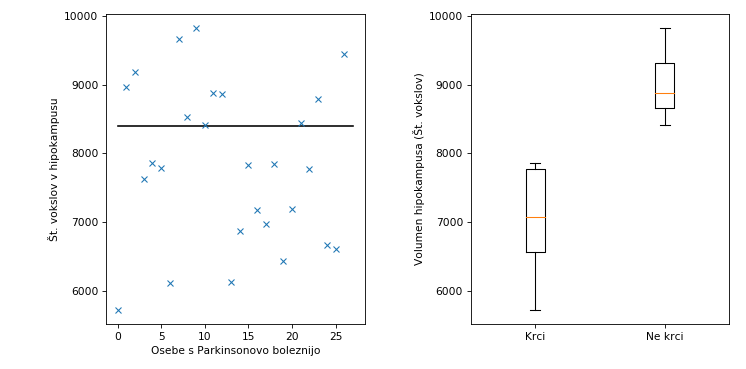

In [141]:
p = Positive; n = Negative

plt.figure()

plt.subplot(121)
plt.plot([0, 27],[volumesControl_average,volumesControl_average], 'k')
plt.plot(volumesParkinson, 'x')
plt.xlabel('Osebe s Parkinsonovo boleznijo')
plt.ylabel('Št. vokslov v hipokampusu', rotation=90)

plt.subplot(122)
PVAL_THRESHOLD = 0.05 
_, pval = mannwhitneyu(p, n)
sig = ('Not Significant','Significant')[int(pval < PVAL_THRESHOLD)]
iAxis = plt.gca()
iAxis.boxplot([p, n],labels=['Krci', 'Ne krci'])
plt.ylabel('Volumen hipokampusa (Št. vokslov)')

plt.tight_layout()

## ---------------------------------------------------------------------------------------------------------------------------------

## ---------------------------------------------------------------------------------------------------------------------------------

## ---------------------------------------------------------------------------------------------------------------------------------

## ---------------------------------------------------------------------------------------------------------------------------------

## ---------------------------------------------------------------------------------------------------------------------------------